# Quick Introduction

The set of notebooks in this folder introduce you to the basic functionalities of `expsolve` for solving differential equation using `expsolve.solvediffeq`. We will import

* `expsolve` as `es`

* `expsolve.discretize.tensorgrid` as `ex` (Fourier and finite difference spatial discretizations on equispaced tensorized grids)

* `expsolve.evolve.splittings.classical` as `split` (classical splittings)

The convention across all notebooks is to use `ex` for the spatial discretization (unless more than one spatial discretization is being considered). Doing so allows us to quickly change spatial discretisation. The examples considered in this folder are

* The linear, non-linear and non-autonomous time-dependent Schrödinger equations (TDSE) in 1D.

The notebooks in this folder are:

* [00_quick_introduction.ipynb](00_quick_introduction.ipynb). This notebook.
* [01_time_stepping_with_evolve.ipynb](01_time_stepping_with_evolve.ipynb). Solving a differential equation, computing its observables and its order of convergence (`timegrid`, `solvediffeq`, `order`).
* [02_classical_splitting.ipynb](02_classical_splitting.ipynb). Classical splitting time steppers, and parameter symmetries (`stepper`, `consistent`, `symmetric`).
* [03_non-autonomous_splitting.ipynb](03_non-autonomous_splitting.ipynb). Handling non-autonomous differential equations with classical splittings.
* [04_nonlinear_splitting.ipynb](04_nonlinear_splitting.ipynb). Handling non-linear differential equations with classical splittings.


*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, abs, real, pi, diag, imag
from torch.linalg import matrix_exp

c:\ProgramData\Anaconda3\envs\torchcomplex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Initial condition - wavepacket

In [2]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)

#### Potential

* time-independent potential `V0`
* time-dependent potential `Vt`
* non-linear potential `Vnl`

In [3]:
V0 = x**4 - 10*x**2

sigma = 0.5
c1 = 5.
c2 = 5.
x0 = -2
Vt = lambda t : c1 * exp(-(x-(x0+t))**2/(2*sigma)) * sin(8*pi*(x-t)) - c2 * sin(5*pi*t) * x

nu = 10.
Vnl = lambda u: nu*abs(u)**2

V = lambda u, t: V0  + Vt(t) + Vnl(u)

#### Prepare stepper

In [4]:
eLu = lambda t, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda t, h, c, u: exp(-1j*c*h*V(u, t))*u    
strangalpha, strangbeta = split.symmetric([],[])
strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

#### Solve differential equation

In [5]:
trange = [0, 1]
timegrid = es.timegrid(trange, ndt=1000)
uT, obsvalues, _ = es.solvediffeq(u, timegrid, strangstep, observables = {'position': lambda u: ex.observable(lambda psi: x*psi, u, xr)})

#### Plot solution

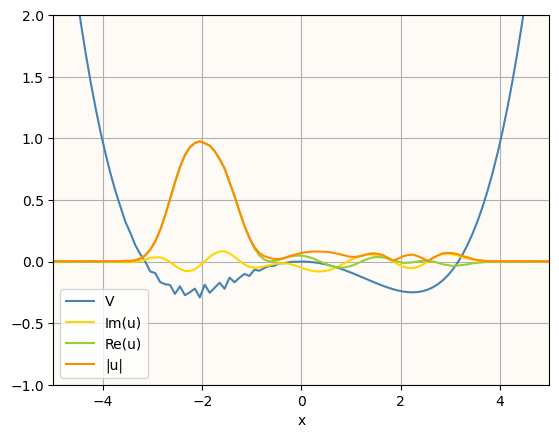

In [6]:
linespecs = lambda u: [((x, (V0 + Vt(timegrid[0]))/100), {'color':mcolors.CSS4_COLORS['steelblue']}, 'V'), 
             ((x, imag(u)), {'color':mcolors.CSS4_COLORS['gold']}, 'Im(u)'),
             ((x, real(u)), {'color':mcolors.CSS4_COLORS['yellowgreen']}, 'Re(u)'),
             ((x, abs(u)), {'color':mcolors.CSS4_COLORS['darkorange']}, '|u|')]

fig, ax = plt.subplots()
ex.plot(ax, linespecs=linespecs(uT), xlim=[-5,5], ylim=[-1,2], xlabel='x')
plt.show()

#### Plot observables

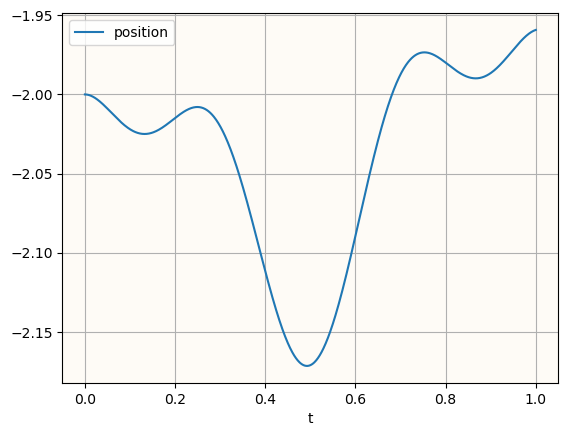

In [7]:
ex.obsplot(plt, timegrid, obsvalues)